In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(784,500)
    self.fc2 = nn.Linear(500, 1000)
    self.fc3 = nn.Linear(1000, 10)

  def forward(self, x):
    x = x.view(-1,784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True, download=True,
                   transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.308,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1000, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106701513.54it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40731571.56it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28390824.96it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20550732.22it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1,keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy:{}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100.* correct / len(test_loader.dataset)))

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
test(model, device, test_loader)
for epoch in range(1, 3 + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

torch.save(model.state_dict(),"mnist.pt")


Test set: Average loss: 2.2889, Accuracy:1131/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss:2.292508
Train Epoch: 1 [12800/60000 (21%)]	Loss:0.370012
Train Epoch: 1 [25600/60000 (43%)]	Loss:0.173397
Train Epoch: 1 [38400/60000 (64%)]	Loss:0.316390
Train Epoch: 1 [51200/60000 (85%)]	Loss:0.263405

Test set: Average loss: 0.1574, Accuracy:9534/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss:0.109182
Train Epoch: 2 [12800/60000 (21%)]	Loss:0.115124
Train Epoch: 2 [25600/60000 (43%)]	Loss:0.076689
Train Epoch: 2 [38400/60000 (64%)]	Loss:0.094189
Train Epoch: 2 [51200/60000 (85%)]	Loss:0.110399

Test set: Average loss: 0.1093, Accuracy:9654/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss:0.153092
Train Epoch: 3 [12800/60000 (21%)]	Loss:0.105280
Train Epoch: 3 [25600/60000 (43%)]	Loss:0.090812
Train Epoch: 3 [38400/60000 (64%)]	Loss:0.087912
Train Epoch: 3 [51200/60000 (85%)]	Loss:0.084266

Test set: Average loss: 0.0860, Accuracy:9733/10000 (97%)



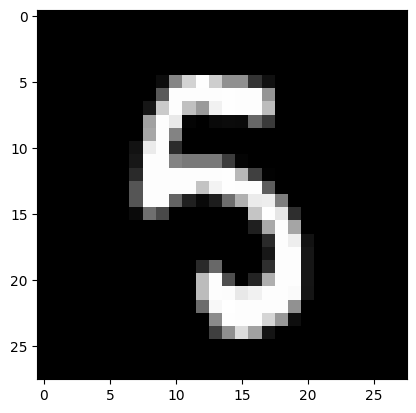

In [13]:
import matplotlib.pyplot as plt
test_image = test_loader.dataset.data[1334]
plt.imshow(test_image, cmap='gray')

In [14]:
out = model(test_image.float().cuda())
out

tensor([[ -776.6572,  -901.5449,  -943.8055,  -408.7809, -1106.8075,     0.0000,
          -854.8722, -1031.4878,  -453.4359,  -313.4505]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [15]:
out.argmax(dim=1)

tensor([5], device='cuda:0')